# Doppler (Interferometry) Radar

This is a Doppler (interferometry) radar simulation example based on `RadarSimPy`.

>`RadarSimPy` is a radar simulation package built with python. **<a href="https://zpeng.me/#contact" target="_blank">Contact me</a> if you are interested in this module.**


This notebook is available on my <a href="https://github.com/rookiepeng/radar-simulation-notebooks" target="_blank">GitHub</a>.

#### Requires

- numpy
- scipy
- plotly (*visualization*)

---


## Radar Model
### Transmitter

The following table lists the basic parameters of the radar transmitter.

| Parameter                       | Variable in `RadarSimPy` | Value      |
|---------------------------------|--------------------------|------------|
| Center frequency ($f_c$)        | fc                       | 24.125 GHz |
| Transmitted power ($P_t$)       | tx_power                 | 10 dBm     |
| Signal length ($T$)             | pulse_length             | 20 s       |

### Receiver
The parameters of the receiver are listed in the table below.

| Parameter                        | Variable in `RadarSimPy` | Value        |
|----------------------------------|--------------------------|--------------|
| Sampling rate ($f_s$)            | fs                       | 20 sps       |
| Noise figure ($NF$)              | noise_figure             | 12 dB        |
| RF gain/loss ($G_{rf}$)          | rf_gain                  | 20 dB        |
| Baseband gain ($G_{BB}$)         | baseband_gain            | 50 dB        |
| Load resistor ($R_L$)            | load_resistor            | 1000 $\Omega$|


In [1]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

tx = Transmitter(f=24.125e9,
                 t=20,
                 tx_power=10,
                 pulses=1,
                 channels=[dict(location=(0, 0, 0))])

rx = Receiver(fs=20,
              noise_figure=12,
              rf_gain=20,
              baseband_gain=50,
              load_resistor=1000,
              channels=[dict(location=(0, 0, 0))])

radar = Radar(transmitter=tx, receiver=rx)

### Targets
The propertities of targets are defined here. There is only one target in this simulaiton. The motion of the target is defined by `1.5+1e-3*np.sin(2*np.pi*1*radar.timestamp)`. `radar.timestamp` is the time matrix of the baseband samples.

In [2]:
target = dict(location=(1.4+1e-3*np.sin(2*np.pi*1*radar.timestamp), 0, 0),
              rcs=-10,
              phase=0)

targets = [target]

## Simulate Baseband Signals

Calculate baseband signal matrix:
$$[channels, pulses, ADC~samples]$$

#### Simulate with Python engine

In [3]:
from radarsimpy import simulator as sim

data = sim(radar, targets)
timestamp = data['timestamp']
baseband = data['baseband']

#### Simulate with C++ engine

In [4]:
from radarsimpy import simulatorcpp as simcpp

data = simcpp(radar, targets)
timestamp = data['timestamp']
baseband = data['baseband']

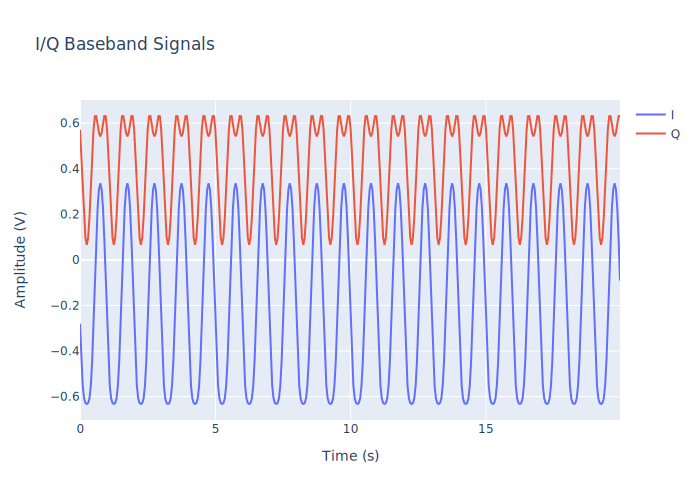

In [5]:
import plotly.graph_objs as go
from plotly.offline import iplot
from IPython.display import SVG, display

beat_I = go.Scatter(
    x=timestamp[0, 0, :],
    y=np.real(baseband[0, 0, :]),
    name='I',
)
beat_Q = go.Scatter(
    x=timestamp[0, 0, :],
    y=np.imag(baseband[0, 0, :]),
    name='Q',
)
data = [beat_I, beat_Q]

layout = go.Layout(
    title='I/Q Baseband Signals',
    yaxis=dict(title='Amplitude (V)'),
    xaxis=dict(title='Time (s)'),
)

fig = go.Figure(data, layout=layout)
# iplot(fig)
display(SVG(fig.to_image(format='svg', scale=1)))

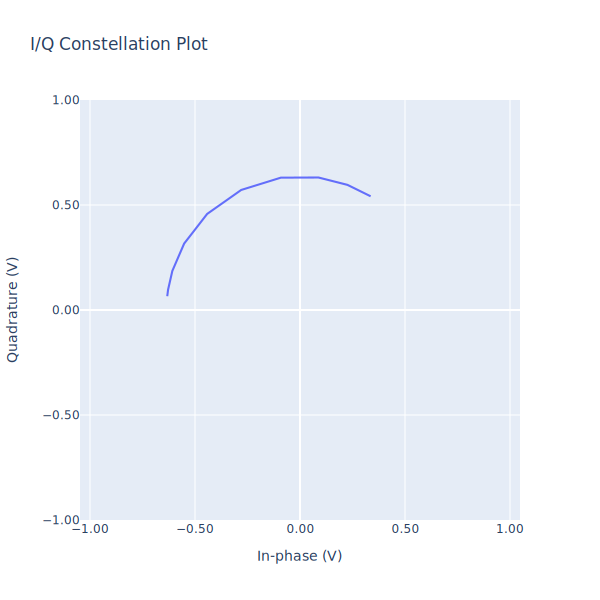

In [6]:
polar = go.Scatter(
    x=np.real(baseband[0, 0, :]),
    y=np.imag(baseband[0, 0, :]),
)

data = [polar]

layout = go.Layout(
    title='I/Q Constellation Plot',
    xaxis=dict(range=[-1, 1], tickformat='.2f', title='In-phase (V)'),
    yaxis=dict(range=[-1, 1],
               tickformat='.2f',
               title='Quadrature (V)',
               scaleanchor="x",
               scaleratio=1),
    height=600,
    width=600,
)

fig = go.Figure(data, layout=layout)
# iplot(fig)
display(SVG(fig.to_image(format='svg', scale=1)))

## Phase demodulation

In [7]:
demod = np.angle(baseband[0, 0, :])

Plot

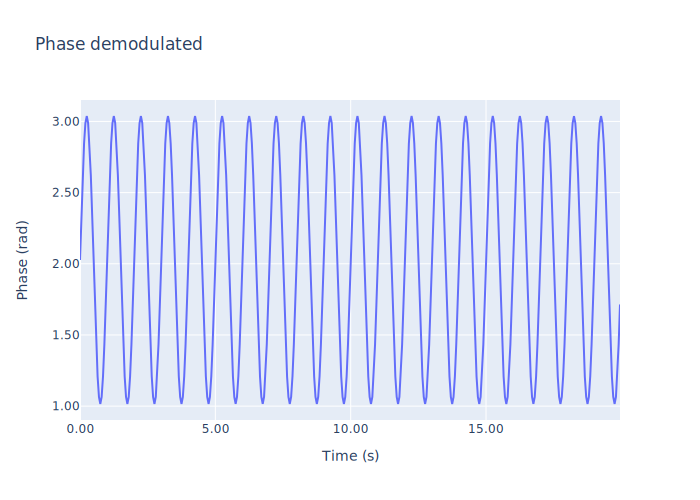

In [8]:
polar = go.Scatter(
    x=timestamp[0, 0, :],
    y=demod,
    # name='I',
)

data = [polar]

layout = go.Layout(
    title='Phase demodulated',
    xaxis=dict(tickformat='.2f', title='Time (s)'),
    yaxis=dict(tickformat='.2f', title='Phase (rad)'),
)

fig = go.Figure(data, layout=layout)
# iplot(fig)
display(SVG(fig.to_image(format='svg', scale=1)))